<small>Este material foi produzido para o *Curso Básico de Google Earth Engine no Python (usando o Google Colab )*. https://www.github.com/andrebelem/Curso_Basico_Geemap. Versão 1.0 | © 2024 Andre Belem
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrebelem/Curso_Basico_Geemap/blob/main/Modulo04_Monitoramento_de_seca.ipynb). Se você tem algum tipo de dúvida ou quiser fazer um comentário, sugestão ou colaborar com este notebook... [![Mail Me](https://img.shields.io/badge/Envie_um-Email-blue)](mailto:andrebelem@id.uff.br)</small>

# Monitoramento de Secas

Agora vamos começar a usar o poder do `EE` para explorar conjuntos de dados sobre secas e analisar padrões. Existem diferentes tipos de secas ([veja aqui](https://drought.unl.edu/Education/DroughtIn-depth/TypesofDrought.aspx)), incluindo seca meteorológica, seca agrícola, seca hidrológica e seca socioeconômica. As secas podem ser monitoradas usando vários índices de seca, como o Índice de Severidade de Seca de Palmer (PDSI - Palmer Drought Severity Index), o Índice Padronizado de Precipitação (SPI - Standardized Precipitation Index) e o Índice Padronizado de Precipitação e Evapotranspiração (SPEI - Standardized Precipitation Evapotranspiration Index).

### Conjuntos de Dados de Seca

Existem vários conjuntos de dados de seca disponíveis no [Catálogo da Comunidade Earth Engine](https://gee-community-catalog.org), mas infelizmente a maioria deles é nos Estados Unidos ou América do Norte (por exemplo, [Monitor de Seca dos Estados Unidos](https://gee-community-catalog.org/projects/usdm) ou [Monitor de Seca da América do Norte (NADM)](https://gee-community-catalog.org/projects/nadm), ou [Perspectiva de Seca Canadense](https://gee-community-catalog.org/projects/can_drought_outlook), ou [Perspectiva Sazonal de Seca dos Estados Unidos](https://gee-community-catalog.org/projects/ussdo)). Porém, alguns deles podem ser usados amplamente pelo mundo:

- [NOAA Evaporative Stress Index (ESI)](https://gee-community-catalog.org/projects/global_esi/). O Índice de Estresse Evaporativo (ESI) da NOAA monitora secas avaliando o estresse hídrico das plantas através de anomalias na evapotranspiração, usando dados de satélite. Ele compara a evapotranspiração real com a potencial, identificando áreas onde a vegetação está sob estresse devido à falta de umidade.
- [CEMS Fire Danger Indices](https://gee-community-catalog.org/projects/cems_fire). Os Índices de Perigo de Incêndio do CEMS avaliam o risco de incêndios florestais usando dados meteorológicos como temperatura, umidade e vento. Desenvolvidos pelo Copernicus Emergency Management Service, eles ajudam na prevenção e resposta a incêndios, fornecendo avaliações em tempo real e previsões para proteger comunidades e recursos naturais.
- [USGS VIIRS Evapotranspiration](https://gee-community-catalog.org/projects/usgs_viirs/). O USGS VIIRS Evapotranspiration usa satélites para estimar taxas de evapotranspiração, fornecendo insights sobre o ciclo da água. Essa medição ajuda a monitorar o uso agrícola da água, avaliar condições de seca e entender respostas ecológicas às mudanças climáticas, auxiliando no gerenciamento de recursos hídricos e planejamento de estratégias de irrigação.

...entre outros (ainda que poucos).

O [Catálogo de Dados Públicos do Earth Engine](https://developers.google.com/earth-engine/datasets/catalog) também hospeda vários [conjuntos de dados de seca](https://developers.google.com/earth-engine/datasets/tags/drought), e entre eles se destaca:

- [SPEIbase: Banco de Dados do Índice Padronizado de Precipitação-Evapotranspiração](https://developers.google.com/earth-engine/datasets/catalog/CSIC_SPEI_2_9). O SPEIbase é um índice global que combina dados de precipitação e evapotranspiração para monitorar secas em diferentes escalas de tempo. Ele permite a avaliação das condições de seca considerando o balanço hídrico, ajudando na análise de impactos climáticos e tendências de umidade do solo.

Vamos explorar o conjunto de dados do SPEIbase no Catálogo da Comunidade Earth Engine.

## Como sempre, vamos autenticar o EE

**Dica**: Você já deve saber como fazer isso !

In [1]:
import ee
import geemap
ee.Authenticate()

True

In [2]:
# Aqui vocẽ deve trocar o projeto pelo "SEU-PROJECT-ID"
ee.Initialize(project='ee-andrebelem')

Como área de pesquisa, vamos olhar a região do Cerrado em Minas Gerais, centrado na cidade de Carrancas, MG. Lembrando que, o Índice Padronizado de Precipitação-Evapotranspiração (SPEI) expressa, como uma variável padronizada (média zero e variância unitária), as desvios do balanço climático atual (precipitação menos evapotranspiração potencial) em relação ao balanço de longo prazo. O período de referência para o cálculo no SPEIbase corresponde a todo o período de estudo. Ser uma variável padronizada significa que a condição SPEI pode ser comparada no espaço e no tempo.

In [3]:
map = geemap.Map(center=[-21.5, -44.6], zoom=8)

collection = ee.ImageCollection("CSIC/SPEI/2_9")
biomas = ee.FeatureCollection("projects/mapbiomas-workspace/AUXILIAR/biomas-2019")
cerrado = biomas.filter(ee.Filter.eq("Bioma", "Cerrado"))

Carrancas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Carrancas")) #<-- note que estamos no nível 2
Brasil = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Brazil")) #<-- note que estamos no nível 0

images = collection.filterDate("2022-01-01", "2023-01-01") #<-- note na página do SPEI que os dados vão até 2023.
spei = images.select('SPEI_12_month') #<--- note que estou escolhendo o acumulado de 12 meses sobre o período selecionado

vis_params = {
    "min": -2.33,
    "max": 2.33,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}
map.add_layer(spei.first(), vis_params, "SPEIbase")
map.add_colorbar(vis_params, label="SPEI index", layer_name="SPEI index")

style = {"color": "000000ff", "width": 1, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(cerrado.style(**style), {}, "Bioma Cerrado")

style2 = {"color": "4b4b4bff", "width": 1, "lineType": "solid", "fillColor": "4b4b4b80"}
map.add_layer(Carrancas.style(**style2), {}, "Município de Carrancas")

style3 = {"color": "000000ff", "width": 2, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(Brasil.style(**style3), {}, "Brasil")

map

Map(center=[-21.5, -44.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

A camada `SPEIbase` representa dados do Índice Padronizado de Precipitação-Evapotranspiração (SPEI), que mede condições de seca em um acumulado de 12 meses (você pode mudar isso de 1 à 48 meses.([veja aqui](https://developers.google.com/earth-engine/datasets/catalog/CSIC_SPEI_2_9#bands)). Note que as cores variam do vermelho (indica condições mais secas) ao azul (indica condições mais úmidas). Na imagem, a cidade de Carrancas (marcada em cinza claro) está na região de transição do Vermelho e Laranja, que indicam áreas de maior seca.Embora a resolução seja baixa (um pixel representa 0,5 grau), é possível entender que essa zona de transição varia dependendo do período escolhido). Note ainda que a camada que destaca o bioma Cerrado é exibida como uma área contornada em cinza escuro, como configurado anteriormente, mostrando onde o bioma está localizado na região. Obviamente este produto não permite uma análise mais regionalizada, mas é potencialmente útil para categorizar algumas regiões.


Vamos agora mudar para o **Índice de Estresse Evaporativo (ESI)** da NOAA, que monitora secas avaliando o estresse hídrico das plantas através de anomalias na evapotranspiração, usando dados de satélite. Basta você copiar o código acima mudando o produto e fazendo as adaptações necessárias.

In [4]:
map = geemap.Map(center=[-21.5, -44.6], zoom=8)

collection = ee.ImageCollection("projects/climate-engine/esi/4wk") #<--- mudei aqui
collection2 = ee.ImageCollection("projects/climate-engine/esi/12wk") #<--- mudei aqui também (mais um produto)

esi_4wk = collection.filterDate("2022-01-01", "2022-02-01")  #<-- note na página do ESI NOAA que os dados vão de 2001 até o presente
esi_12wk = collection2.filterDate("2022-01-01", "2023-01-01")

biomas = ee.FeatureCollection("projects/mapbiomas-workspace/AUXILIAR/biomas-2019")
cerrado = biomas.filter(ee.Filter.eq("Bioma", "Cerrado"))

Carrancas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Carrancas")) #<-- note que estamos no nível 2
Brasil = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Brazil")) #<-- note que estamos no nível 0


vis_params = {
    "min": -2.5,
    "max": 2.5,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}
map.add_layer(esi_4wk.first(), vis_params, "ESI 4-semanas (ESI_4wk)")
map.add_layer(esi_12wk.first(), vis_params, "ESI 12-semanas (ESI_12wk)")

map.add_colorbar(vis_params, label="ESI index", layer_name="ESI") #<--- note que ele uma distribuição muito parecida com o SPEI

style = {"color": "000000ff", "width": 1, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(cerrado.style(**style), {}, "Bioma Cerrado")

style2 = {"color": "4b4b4bff", "width": 1, "lineType": "solid", "fillColor": "4b4b4b80"}
map.add_layer(Carrancas.style(**style2), {}, "Município de Carrancas")

style3 = {"color": "000000ff", "width": 2, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(Brasil.style(**style3), {}, "Brasil")

map

Map(center=[-21.5, -44.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

Aqui você deve ter notado que plotamos dois produtos, o ESI para 4 semanas e para 12 semanas, e ele tem uma resolução melhor que o SPIE. O **Índice de Estresse Evaporativo (ESI)** é um indicador térmico das condições anômalas de evapotranspiração (ET) que pode ser usado para monitoramento de secas. O ESI descreve anomalias temporais na evapotranspiração, destacando áreas com taxas anormalmente altas ou baixas de uso de água na superfície terrestre, e a comparação entre 4- e 12- semanas do acumulado permite inferir áreas que começam a apresentar um potencial de queda do índice.

### TerraClimate

Talvez um dos mais populares produtos aqui é o [TerraClimate](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE), um conjunto de dados de clima mensal e balanço hídrico climático para superfícies terrestres globais. Ele utiliza um esquema de *interpolação climática*, que combina normais climatológicas de alta resolução espacial do conjunto de dados [WorldClim](https://www.worldclim.org/) com dados de resolução espacial mais grosseira, mas com variáveis ao longo do tempo, do [CRU Ts4.0](https://data.ceda.ac.uk/badc/cru/data/cru_ts/) e da Reanálise Japonesa de 55 anos ([JRA55](https://jra.kishou.go.jp/JRA-55/index_en.html)). Conceitualmente, o procedimento aplica anomalias temporais interpoladas do CRU Ts4.0/JRA55 à climatologia de alta resolução espacial do WorldClim para criar um conjunto de dados de alta resolução espacial que cobre um registro temporal mais amplo.

O TerraClimate também produz conjuntos de dados mensais de balanço hídrico de superfície usando um modelo de balanço hídrico que incorpora evapotranspiração de referência, precipitação, temperatura e capacidade de água extraível do solo interpolada. Um modelo climático de balanço hídrico de Thornthwaite-Mather modificado e dados de capacidade de armazenamento de água extraível do solo foram usados em uma grade de 0,5° de Wang-Erlandsson et al. (2016).


Mais uma vez, precisamos apenas copiar o código acima:

In [5]:
map = geemap.Map(center=[-21.5, -44.6], zoom=8)

collection = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE") #<--- mudei aqui para o Terra Climate

# note que vocẽ tem várias opções aqui https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands
# neste caso, vou escolher o Palmer Drought Severity Index PDSI

pdsi = collection.select("pdsi").filterDate("2023-06-01", "2023-07-01")  #<-- Mudei para representar o inverno de 2023

biomas = ee.FeatureCollection("projects/mapbiomas-workspace/AUXILIAR/biomas-2019")
cerrado = biomas.filter(ee.Filter.eq("Bioma", "Cerrado"))

Carrancas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Carrancas")) #<-- note que estamos no nível 2
Brasil = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Brazil")) #<-- note que estamos no nível 0


vis_params = {
    "min": -4000, #<--- note que preciso ajustar o max e min relativo à banda pdsi* Veja a explicação abaixo
    "max": 3000,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}

vis_params2 = {
    "min": -4, #<--- note que esta é uma Cópia da colorbar acima, mas divido por mil
    "max": 3,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}

map.add_layer(pdsi.first(), vis_params, "Palmer Drought Severity Index")
map.add_colorbar(vis_params2, label="PDSI index", layer_name="PDSI")

style = {"color": "000000ff", "width": 1, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(cerrado.style(**style), {}, "Bioma Cerrado")

style2 = {"color": "4b4b4bff", "width": 1, "lineType": "solid", "fillColor": "4b4b4b80"}
map.add_layer(Carrancas.style(**style2), {}, "Município de Carrancas")

style3 = {"color": "000000ff", "width": 2, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(Brasil.style(**style3), {}, "Brasil")

map

Map(center=[-21.5, -44.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

O Palmer Drought Severity Index (PDSI) é uma medida meteorológica que quantifica a severidade da seca em uma região específica. O índice leva em consideração a temperatura, a precipitação e a capacidade do solo de reter água, entre outros fatores. De forma numérica, a interpretação dos valores é dada pelo valor do pixel do TerraClimate, dividido por 1000. Por exemplo, -2345 seria interpretado como -2.345. A tabela abaixo representa o significado do índice:

- Extremamente Úmido: > 4
- Muito Úmido: 3 a 4
- Moderadamente Úmido: 2 a 3
- Levemente Úmido: 1 a 2
- Normal: -1 a 1
- Seca Leve: -1 a -2
- Seca Moderada: -2 a -3
- Seca Severa: -3 a -4
- Seca Extrema: < -4

Podemos simplesmente alterar os valores no mapa conforme o código abaixo (note que ajustei os valores de min e max):

In [6]:
map = geemap.Map(center=[-21.5, -44.6], zoom=8)

collection = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE") #<--- mudei aqui para o Terra Climate

# note que vocẽ tem várias opções aqui https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands
# neste caso, vou escolher o Palmer Drought Severity Index PDSI

pdsi = collection.select("pdsi").filterDate("2023-06-01", "2023-07-01")  #<-- Mudei para representar o inverno de 2023

biomas = ee.FeatureCollection("projects/mapbiomas-workspace/AUXILIAR/biomas-2019")
cerrado = biomas.filter(ee.Filter.eq("Bioma", "Cerrado"))

Carrancas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Carrancas")) #<-- note que estamos no nível 2
Brasil = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Brazil")) #<-- note que estamos no nível 0


vis_params = {
    "min": -1000, #<--- note que preciso ajustar o max e min relativo à banda pdsi* Veja a explicação abaixo
    "max": 1000,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}

vis_params2 = {
    "min": -1, #<--- note que esta é uma Cópia da colorbar acima, mas divido por mil
    "max": 1,
    "palette": [
    '8b1a1a', 'de2929', 'f3641d',
    'fdc404', '9afa94', '03f2fd',
    '12adf3', '1771de', '00008b',
    ]
}

map.add_layer(pdsi.first(), vis_params, "Palmer Drought Severity Index")
map.add_colorbar(vis_params2, label="PDSI index", layer_name="PDSI")

style = {"color": "000000ff", "width": 1, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(cerrado.style(**style), {}, "Bioma Cerrado")

style2 = {"color": "4b4b4bff", "width": 1, "lineType": "solid", "fillColor": "4b4b4b80"}
map.add_layer(Carrancas.style(**style2), {}, "Município de Carrancas")

style3 = {"color": "000000ff", "width": 2, "lineType": "solid", "fillColor": "00000000"}
map.add_layer(Brasil.style(**style3), {}, "Brasil")

map

Map(center=[-21.5, -44.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

A grande vantagem do TerraClimate é a resolução espacial, boa o suficiente para o monitoramento de áreas menores.

## Extraindo Séries Temporais

Basicamente o que vamos fazer aqui é criar um mapa e definir uma região de interesse, e extrair todas as informações daquela área, por tempo, como uma série temporal.

Vou usar como exemplo, a região de Carrancas em Minas Gerais, mas você pode também desenhar um retângulo em qualquer área do mapa se assim desejar.

In [7]:
# em princípio não precisamos repetir isso, porque já foi executado ali atrás, mas por consistência, decidi colocar aqui
Carrancas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Carrancas"))
carrancas_centroid = Carrancas.geometry().centroid()
carrancas_point = ee.Geometry.Point(carrancas_centroid.coordinates())

map = geemap.Map(center=[-21.5, -44.6], zoom=10)
map.add_basemap("Esri.WorldImagery")
# Adicionar o ponto ao mapa
map.addLayer(carrancas_point, {'color': 'red'}, 'Centro de Carrancas')
map.addLayer(Carrancas, {'color': 'green'}, 'Carrancas')
map

Map(center=[-21.5, -44.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

Note que é feito uma "extração de dados" em cima do `roi` definido, e logo em seguida, usamos a função `geemap.zonal_stats` para calcular a média (e o desvio padrão), convertendo para um dataframe com `geemap.ee_to_df`. O problema é que o formato de saida é completamente "estranho" e ilegível à primeira vista, mas se você examinar o resultado, vai ver que o index do dataframe é uma composição da 'data' e do nome da variável (yyyymm_pdsi). Com um pouco de "phytonismo" podemos converter essas informações em uma série temporal.

In [8]:
# agora, vou verificar se você desenhou um retângulo
if map.user_roi is not None:
    roi = map.user_roi
else:
    roi = Carrancas

# Agora vou separar datasets do TerraClimate
pdsi_col = (
    ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
    .select("pdsi")
    .map(lambda img: img.clipToCollection(roi))
)
soil_col = (     #<--- note que estou usando a variável SOIL que é "Soil moisture, derived using a one-dimensional soil water balance model"
    ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
    .select("soil")
    .map(lambda img: img.clipToCollection(roi))
)

In [9]:
# agora vou calcular a média dentro do ROI e converter
pdsi_ts = geemap.zonal_stats(pdsi_col,roi,stats_type="MEAN",scale=1000,return_fc=True,verbose=True)
pdsi_df = geemap.ee_to_df(pdsi_ts)

Computing statistics ...


In [10]:
# examine o dataframe mas *não se assuste* !
pdsi_df

,195801_pdsi,195802_pdsi,195803_pdsi,195804_pdsi,195805_pdsi,195806_pdsi,195807_pdsi,195808_pdsi,195809_pdsi,195810_pdsi,...,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,STATUS,STR2_YEAR,Shape_Area,Shape_Leng
0,-28.483167,-103.077916,54.469127,104.15647,152.310886,173.99006,254.469431,242.449187,249.668072,257.914154,...,677,Minas Gerais,8030,Carrancas,NO,3000,Member State,1000,0.063455,1.537264


In [11]:
# e um pouco de pythonismo
import pandas as pd

pdsi_columns = [col for col in pdsi_df.columns if "pdsi" in col.lower()]
pdsi_df = pdsi_df[pdsi_columns]
pdsi_df = pdsi_df.T
pdsi_df.columns = ["pdsi"]
pdsi_df['time'] = pd.to_datetime(pdsi_df.index.str.split("_").str[0],format='%Y%m')
pdsi_df = pdsi_df.set_index('time')
pdsi_df.head()

,pdsi
time,
1958-01-01,-28.483167
1958-02-01,-103.077916
1958-03-01,54.469127
1958-04-01,104.156470
1958-05-01,152.310886


Basta fazer o mesmo para soil, e por fim, juntar os dois dataframes...

In [12]:
# calculando a média dentro do ROI e converter
soil_ts = geemap.zonal_stats(soil_col,roi,stats_type="MEAN",scale=1000,return_fc=True,verbose=True)
soil_df = geemap.ee_to_df(soil_ts)

soil_columns = [col for col in soil_df.columns if "soil" in col.lower()]
soil_df = soil_df[soil_columns]
soil_df = soil_df.T
soil_df.columns = ["soil"]
soil_df['time'] = pd.to_datetime(soil_df.index.str.split("_").str[0],format='%Y%m')
soil_df = soil_df.set_index('time')

Computing statistics ...


In [13]:
# combinando...
df_carrancas = pd.concat([pdsi_df/1000,soil_df],axis=1)

Lembrando que a operação de dividir por 1000 acima é para transformar no índex que vai de -4 à 4 (não confunda o `soil`, que é dado em mm). Agora basta graficar ... A pergunta aqui é: **será que o PDSI e Soil Moisture tem piorado ao longo do tempo na região de Carrancas MG ?**. Para isso, vou calcular uma "climatologia" entre 1981 e 2020, e plotar os dados de 2023 por cima do gráfico.

In [14]:
# gerando algumas estatisticas ...

# primeiro, vou agrupar os dados por mes
df_carrancas['month'] = df_carrancas.index.month

# Agora, vou separar os dados de 1981 à 2020
df_carrancas_clima = df_carrancas.loc['1981-01-01':'2020-12-31']

# Calcula min/max e desvio padrão por mes
min_pdsi = df_carrancas_clima.groupby('month')['pdsi'].min()
max_pdsi = df_carrancas_clima.groupby('month')['pdsi'].max()
std_dev = df_carrancas_clima.groupby('month')['pdsi'].std()
mean_pdsi = df_carrancas_clima.groupby('month')['pdsi'].mean()

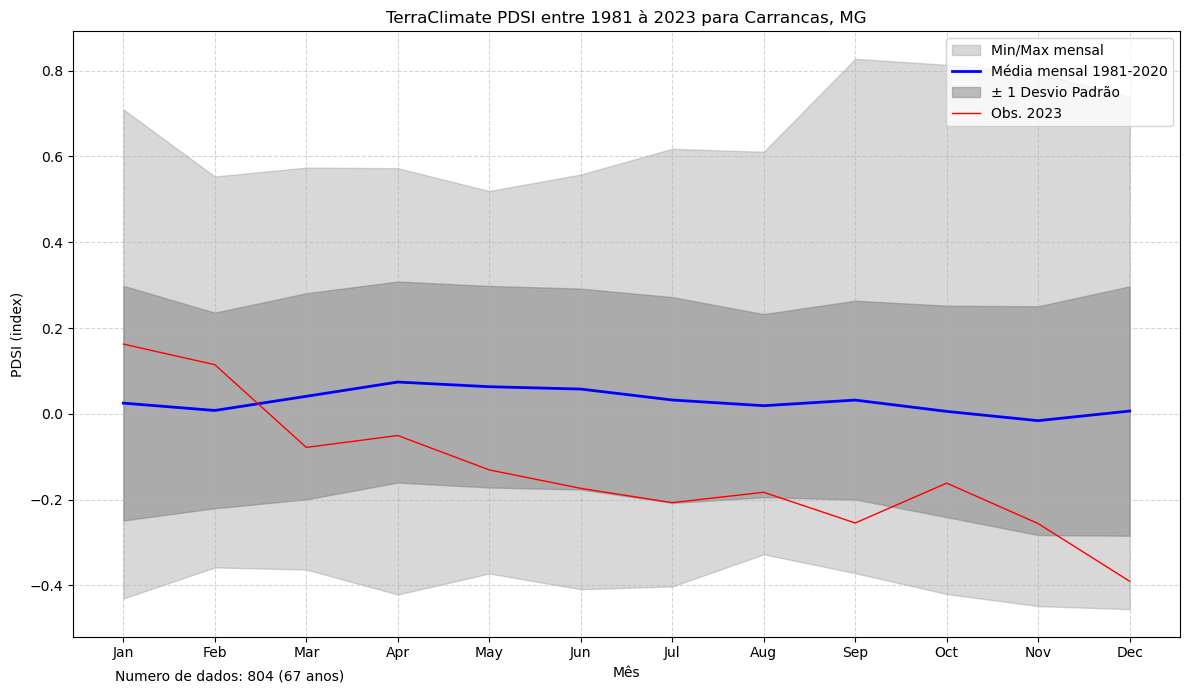

In [15]:
import matplotlib.pyplot as plt

# Configuração geral da figura
plt.figure(figsize=(12, 7))

# Plota min/max mensal com fill_between baseado no month
plt.fill_between(min_pdsi.index, min_pdsi, max_pdsi, color='gray', alpha=0.3, label='Min/Max mensal')

# Plota a média por mês
plt.plot(mean_pdsi.index, mean_pdsi, color='blue', linewidth=2, label='Média mensal 1981-2020')

# Plota a banda de desvio padrão
plt.fill_between(std_dev.index, mean_pdsi - std_dev, mean_pdsi + std_dev, color='gray', alpha=0.5, label='± 1 Desvio Padrão')

# Plota as observações de 2023
plt.plot(df_carrancas.loc['2023'].month, df_carrancas.loc['2023']['pdsi'],
         color='red', linestyle='-', linewidth=1, label='Obs. 2023')

# Adiciona título e rótulos
plt.title('TerraClimate PDSI entre 1981 à 2023 para Carrancas, MG')
plt.xlabel('Mês')
plt.ylabel('PDSI (index)')

# Adiciona legenda
plt.legend(loc='upper right', frameon=True)

# Ajusta ticks do eixo x para meses
ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Aproximadamente o início de cada mês
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=ticks, labels=labels)

# Adiciona grid
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir total de registros e tempo de geração no rodapé
plt.figtext(0.1, 0.02, f'Numero de dados: {len(df_carrancas)} ({len(set(df_carrancas.index.year))} anos)', ha='left')

# Exibir o gráfico
plt.tight_layout()
plt.show()

Vamos avaliar a evolução dos dois...

In [16]:
# aqui é muito útil que você analise a distribuição dos dados.
df_carrancas.describe()

,pdsi,soil,month
count,804.000000,804.000000,804.000000
mean,-0.003515,534.038166,6.500000
std,0.241645,292.581501,3.454201
min,-0.593841,86.967267,1.000000
25%,-0.173673,209.657307,3.750000
50%,-0.046984,596.629109,6.500000
75%,0.176603,827.192321,9.250000
max,0.827585,827.192321,12.000000


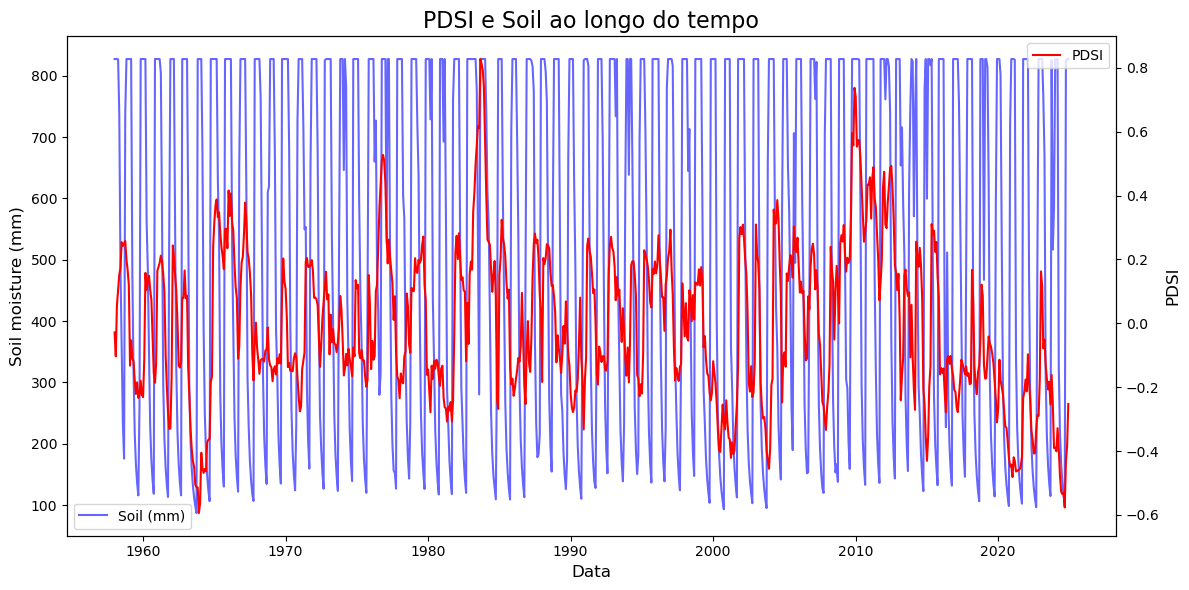

In [17]:
import seaborn as sns

# Criando o gráfico combinado
plt.figure(figsize=(12, 6))

# Gráfico de barras para soil
sns.lineplot(x=df_carrancas.index, y='soil', data=df_carrancas, color='blue', alpha=0.6, label='Soil (mm)', linewidth=1.5)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Soil moisture (mm)', fontsize=12)

## Gráfico de linha para pdsi
ax2 = plt.twinx()
sns.lineplot(x=df_carrancas.index, y='pdsi', data=df_carrancas, color='red', label='PDSI', linewidth=1.5, ax=ax2)

# Configurações do gráfico
plt.title('PDSI e Soil ao longo do tempo', fontsize=16)
ax2.set_ylabel('PDSI', fontsize=12)

plt.xticks(rotation=45)
plt.grid(False)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Note que curiosamente, a umidade do solo não apresenta uma relação com o PDSI. A falta de relação aparente entre a umidade do solo (Soil Moisture) e o Índice de Severidade de Secas de Palmer (PDSI) pode ser atribuída a uma série de fatores complexos. Devemos lembrar que o PDSI é calculado com base em médias mensais, considerando fatores como precipitação, temperatura e evapotranspiração em uma escala regional. Ele é projetado para identificar secas prolongadas, mas ao mesmo tempo o PDSI é altamente sensível às anomalias climáticas e pode refletir condições de seca que não afetam imediatamente a umidade do solo. Já a umidade do solo pode variar significativamente em pequenas escalas espaciais devido a diferenças locais no tipo de solo, topografia e uso da terra, além de responder rapidamente a eventos de precipitação, enquanto o PDSI pode não capturar essas variações de curto prazo. Porém, você pode explorar muito mais aqui !

### Exercício proposto 4 - Analisando séries de PDSI

Explore o PDSI em uma área onde você sabe que a variação sazonal é bem grande (por exemplo, alguma cidade do RS). Você pode ainda extrair outras bandas do produto [TerraClimate](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands) para fazer correlações. Use sua criatividade !

In [18]:
# Escreva seu código aqui ou crie um notebook separado